# Hyperparameter Optimization with aqua-blue

Prediction accuracy is highly correlated to the hyperparameters of a reservoir computer. The `hyper_opt` module provides functionality to optimize hyperparameters through random search algorithms. **Note that this is an experimental feature and is subject to change. Any feedback is appreciated.**

## Aqua-blue Hyperparameters
Aqua-blue models have 4 hyperparameters with significant effect on prediction accuracy. 

### Spectral Radius ($r_s$)
The spectral radius is the largest absolute eigenvalue of the reservoir weight matrix, $W_{res}$. It controls the echo state property of the system, ensuring that memory of past states gradually fades over time. The approximate ranges which define behavior for general use cases are given below, however the best way to determine the optimal $s_r$ for a task is using an optimization algorithm.
$$r_s < 1 \to \text{ stable dynamics, past states fade quickly}$$
$$r_s \approx 1 \to \text{ balance between past states and current input}$$ 
$$r_s > 1 \to \text{ chaotic dynamics, could lead to numerical instability }$$

### Sparsity
The sparsity is the proportion of zero entries in the reservoir weight matrix $W_{res}$. It determines the extent of connection between neurons. Higher sparsity values lead to reduced computation at the cost of higher overfitting risk. Lower sparsity values increase neuron connection density, which leads to more complex dynamics at the price of higher computational cost.

### Leaking Rate ($\alpha$) 
The leaking rate controls the priority of past states versus current states. At each timestep, 
    $$y_t = (1 - \alpha) y_{t-1} + \alpha f(W_\text{in} x_t + W_\text{res} y_{t-1})$$
where $y_t$ and $y_{t-1}$ are reservoir states and $x_t$ is an input state. Therefore, the leaking rate is directly proportional to how fast the model updates.

### rcond 
The output later is trained using ridge regression, which involves computing the Moore-Penrose pseudo-inverse. `rcond` is a cutoff for small singular values, which is used to improve numerical stability.

## Basic Hyperparameter Optimization

The `hyper_opt` module implements certain classes to simplify usage of the `hyperopt` package. We will demonstrate its usage with an example. Before we proceed, we will install the required dependencies using

In [ ]:
pip install .[hyper]

Let's define a time series that we want to predict the future of.

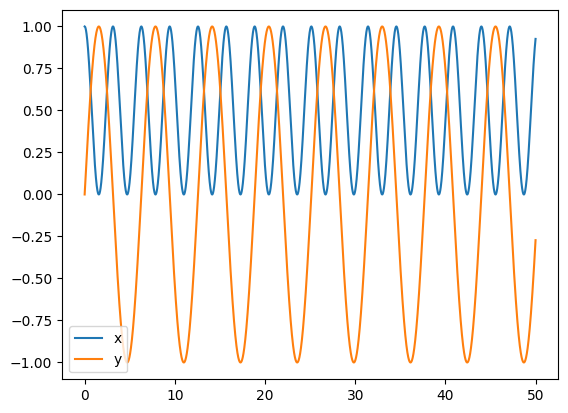

In [19]:
import numpy as np 
import aqua_blue 
import matplotlib.pyplot as plt 

t = np.arange(5_000) / 100
y = np.vstack((np.cos(t) ** 2, np.sin(t))).T

time_series = aqua_blue.time_series.TimeSeries(dependent_variable=y, times=t)

plt.plot(time_series.times, time_series.dependent_variable, label=['x', 'y'])
plt.legend()
plt.show()

We want to predict `1000` timesteps into the future. Since this is a simple function, we can compute the actual future easily.

In [8]:
horizon = 1000
p_times = np.linspace(t[-1], t[-1] + horizon*np.diff(t)[0], horizon)
actual_future =  np.vstack((np.cos(p_times) ** 2, np.sin(p_times))).T

We will also use a NumPy PRNG to generate our weight matrices.

In [9]:
generator = np.random.default_rng(seed=0)
w_res = generator.uniform(
    low=-0.5,
    high=0.5,
    size=(100, 100)
)
w_in = generator.uniform(
    low=-0.5,
    high=0.5,
    size=(100, 2)
)

First, we will predict with the default hyperparameters.

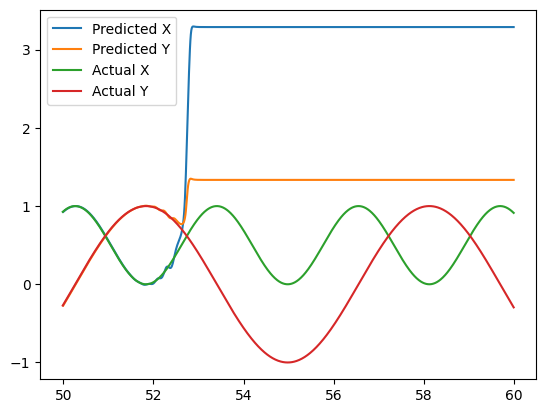

In [21]:
normalizer = aqua_blue.utilities.Normalizer()

n_ts = normalizer.normalize(time_series)

model = aqua_blue.models.Model(
    aqua_blue.reservoirs.DynamicalReservoir(
        input_dimensionality=2,
        reservoir_dimensionality=100, 
        w_in=w_in, 
        w_res=w_res, 
    ),
    readout=aqua_blue.readouts.LinearReadout()
)
model.train(n_ts) 

prediction = normalizer.denormalize(model.predict(horizon))

plt.plot(prediction.times, prediction.dependent_variable, label=['Predicted X', 'Predicted Y'])
plt.plot(p_times, actual_future, label=["Actual X", "Actual Y"])
plt.legend()
plt.show()

As expected, the prediction is pretty poor because the hyperparameters aren't tuned for this specific problem. To do so, we start by defining a `ModelParams` object, which provides information about the model to the optimizer.

In [23]:
mp = aqua_blue.hyper_opt.ModelParams(
    time_series=time_series,
    input_dimensionality=2, 
    reservoir_dimensionality=100,
    w_in=w_in,
    w_res=w_res, 
    horizon=horizon,
    actual_future=actual_future
)

Now, we need a way of computing how good our prediction is. We will use the RMSE as a metric for this example, which is the metric that `hyper_opt` defaults to. We will run our optimizer for 1000 iterations.

In [25]:
fmin = aqua_blue.hyper_opt.default_loss(mp)
evals = 1000

Let's create an `Optimizer` and pass the objective function and number of iterations. Then, we call the `.optimize()` method to get the optimal hyperparameters. Note that this will take time, depending on your system requirements. 

In [28]:
optimizer = aqua_blue.hyper_opt.Optimizer(fn=fmin, max_evals=evals)
best_params = optimizer.optimize()

  0%|          | 1/1000 [00:00<02:23,  6.94trial/s, best loss: 0.9803264822077419]

c:\Users\hkbel\Desktop\ccmc\aqua-blue\venv\Lib\site-packages\aqua_blue\hyper_opt.py:168: UserWarning: This feature is currently experimental and may be unstable or subject to change. Feedback is welcome to help improve future versions.
  warnings.warn("This feature is currently experimental and may be unstable or subject to change. Feedback is welcome to help improve future versions.", UserWarning)


100%|██████████| 1000/1000 [02:49<00:00,  5.89trial/s, best loss: 0.03355844026253749]


We have our optimal hyperparameters! To verify that the optimizer has done its job, let's create a model with these parameters and make a prediction - 

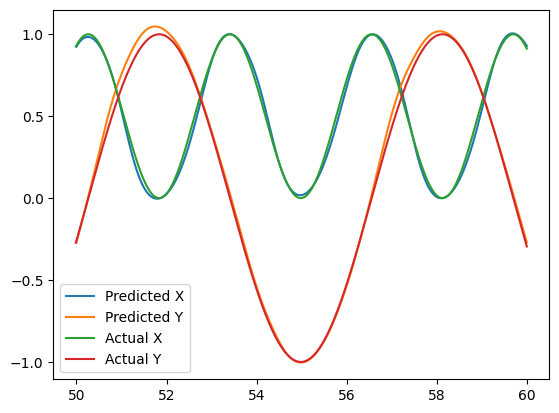

In [29]:
normalizer = aqua_blue.utilities.Normalizer()

n_ts = normalizer.normalize(time_series)

model = aqua_blue.models.Model(
    aqua_blue.reservoirs.DynamicalReservoir(
        input_dimensionality=2,
        reservoir_dimensionality=100, 
        w_in=w_in, 
        w_res=w_res, 
        spectral_radius=best_params['spectral_radius'], 
        sparsity=best_params['sparsity'],
        leaking_rate=best_params['leaking_rate'], 
    ),
    readout=aqua_blue.readouts.LinearReadout(rcond=best_params['rcond'])
)
model.train(n_ts) 

prediction = normalizer.denormalize(model.predict(horizon))

plt.plot(prediction.times, prediction.dependent_variable, label=['Predicted X', 'Predicted Y'])
plt.plot(p_times, actual_future, label=["Actual X", "Actual Y"])
plt.legend()
plt.show()

Now, our prediction is looking a lot nicer! We've successfully performed hyperparameter optimization using `hyper_opt`!